### NLI

A large annotated corpus for learning natural language inference by [Bowman et al.](https://arxiv.org/pdf/1508.05326v1.pdf)

In [1]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [2]:
ls entailment/data

glove.6B.zip  labels.npz  labels.txt  snli_1.0.zip  vocab.txt


#### Dataset reader

The dataset is too large to fit into the memory, we will need to build a dataset reader. 

We will include the text preprocessor into the python generator.

In [3]:
import unicodedata
import re
def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess(w):
        w = unicode_to_ascii(w.lower().strip())
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w

In [4]:
import os
import zipfile
import io
import numpy as np
from tqdm import tqdm
import tensorflow as tf
zip_file_name = 'entailment/data/snli_1.0.zip'
output_file_name = 'snli_1.0/snli_1.0_train.txt'

def read_zip_csv(filename):
    counter = 0
    columns = ['gold_label','sentence1','sentence2']
    indices = [-1, -1, -1]
    with zipfile.ZipFile(zip_file_name) as z:
        for info in z.infolist():
            if output_file_name in info.filename:
                # read the file
                print("Reading lines from file {}".format(output_file_name))
                with io.TextIOWrapper(z.open(output_file_name), encoding="utf-8") as f:
                    for line in tqdm(f):
                        terms = line.split('\t')
                        if np.min(indices) == -1: # this is the first line
                            indices = [np.where(np.array(terms) == val)[0] for val in columns]
                            counter += 1
                        else:
                            idx = [i[0] for i in indices]
                            #do not include the '-' label
                            if np.array(terms)[idx][0] != '-':
                                data = np.array(terms)[idx]
                                #print("d1=", data[1])
                                lbl, hyp, evi = data
                                data = [lbl, preprocess(hyp), preprocess(evi)]
                                yield data


n_features = 3
def get_dataset():
    generator = lambda: read_zip_csv(zip_file_name)
    return tf.data.Dataset.from_generator(
        generator, (tf.string), (n_features), ())

In [5]:
for d in get_dataset().take(5):
    print(d[1])

5it [00:00, 904.76it/s]

Reading lines from file snli_1.0/snli_1.0_train.txt
tf.Tensor(b'<start> a person on a horse jumps over a broken down airplane . <end>', shape=(), dtype=string)
tf.Tensor(b'<start> a person on a horse jumps over a broken down airplane . <end>', shape=(), dtype=string)
tf.Tensor(b'<start> a person on a horse jumps over a broken down airplane . <end>', shape=(), dtype=string)
tf.Tensor(b'<start> children smiling and waving at camera <end>', shape=(), dtype=string)
tf.Tensor(b'<start> children smiling and waving at camera <end>', shape=(), dtype=string)


In [8]:
raw_ds = get_dataset()

In [9]:
next(iter(raw_ds)).numpy()

1it [00:00, 820.80it/s]

Reading lines from file snli_1.0/snli_1.0_train.txt


array([b'neutral',
       b'<start> a person on a horse jumps over a broken down airplane . <end>',
       b'<start> a person is training his horse for a competition . <end>'],
      dtype=object)

The texts are available in two columns, the hypothesis and the evidence. We will need to concatenate them if we wish to send them to a tokenizer.

In [11]:
mapped_ds = raw_ds.map(lambda x: tf.strings.join([x[1], x[2]], separator=" "))

We need tensorflow_text for using pre built bert tokenizers.

The tensorflow text needs tensorflow 2.5.0, so we will need to install the tensorflow-gpu version 2.5.0 as well, when using the Deep learning AMI in AWS.

In [12]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

The bert_vocab_from_dataset can efficiently handle processing of the texts in the training dataset, as we send them in to the vocab builder batch by batch.

In [13]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]", "<start>", "<end>"]
bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [14]:
%%time
pt_vocab = bert_vocab.bert_vocab_from_dataset(
    mapped_ds.batch(1000).prefetch(2),
    **bert_vocab_args
)

414it [00:00, 4131.57it/s]

Reading lines from file snli_1.0/snli_1.0_train.txt


550153it [02:10, 4222.80it/s]


CPU times: user 4min 29s, sys: 24.4 s, total: 4min 54s
Wall time: 3min 23s


In [15]:
print(pt_vocab[:10])
print(pt_vocab[100:110])

['[PAD]', '[UNK]', '[START]', '[END]', '<start>', '<end>', '!', ',', '.', '<']
['##s', 'running', 'yellow', 'has', 'riding', 'ball', 'out', 'brown', 'hat', 'next']


In [16]:
def write_vocab_file(filepath, vocab):
    print("Saving vocab file to {}".format(filepath))
    with open(filepath, 'w') as f:
        for token in vocab:
            print(token, file=f)

In [18]:
vocab_file_out = 'entailment/data/vocab.txt'
write_vocab_file(vocab_file_out, pt_vocab)

Saving vocab file to entailment/data/vocab.txt


In [20]:
!wc -l entailment/data/vocab.txt

7882 entailment/data/vocab.txt


Note: our basic tokenizer had 14863 words only from 200K documents. We have restricted the vocab to only 8K here.

In [5]:
import os
import zipfile
import io
import numpy as np
from tqdm import tqdm
zip_file_name = 'entailment/data/snli_1.0.zip'
output_file_name = 'snli_1.0/snli_1.0_train.txt'

def load_data(num_samples=10):
    counter = 0
    columns = ['gold_label','sentence1','sentence2']
    indices = [-1, -1, -1]
    data = []
    with zipfile.ZipFile(zip_file_name) as z:
        for info in z.infolist():
            if output_file_name in info.filename:
                # read the file
                print("Reading lines from file {}".format(output_file_name))
                with io.TextIOWrapper(z.open(output_file_name), encoding="utf-8") as f:
                    for line in tqdm(f):
                        terms = line.split('\t')
                        if np.min(indices) == -1: # this is the first line
                            indices = [np.where(np.array(terms) == val)[0] for val in columns]
                            counter += 1
                        else:
                            idx = [i[0] for i in indices]
                            #do not include the '-' label
                            if np.array(terms)[idx][0] != '-':
                                data.append(np.array(terms)[idx])
                                counter += 1
                        if (num_samples > -1) & (counter > num_samples):
                            return data

In [40]:
data = load_data(300000)
print("Read {} records".format(len(data)))

3566it [00:00, 35658.16it/s]

Reading lines from file snli_1.0/snli_1.0_train.txt


300382it [00:08, 35900.86it/s]

Read 300000 records


In [41]:
data[:3]

[array(['neutral',
        'A person on a horse jumps over a broken down airplane.',
        'A person is training his horse for a competition.'], dtype='<U161'),
 array(['contradiction',
        'A person on a horse jumps over a broken down airplane.',
        'A person is at a diner, ordering an omelette.'], dtype='<U161'),
 array(['entailment',
        'A person on a horse jumps over a broken down airplane.',
        'A person is outdoors, on a horse.'], dtype='<U161')]

In [42]:
data = [[d[0], d[1],d[2]] for d in data[:]]

In [43]:
data[:3]

[['neutral',
  'A person on a horse jumps over a broken down airplane.',
  'A person is training his horse for a competition.'],
 ['contradiction',
  'A person on a horse jumps over a broken down airplane.',
  'A person is at a diner, ordering an omelette.'],
 ['entailment',
  'A person on a horse jumps over a broken down airplane.',
  'A person is outdoors, on a horse.']]

##### Prepare the input data

- Tokenize the sentences


In [10]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.5.0


In [44]:
import unicodedata
import re
def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def preprocess(w):
        w = unicode_to_ascii(w.lower().strip())
        # creating a space between a word and the punctuation following it
        # eg: "he is a boy." => "he is a boy ."
        # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
        w = re.sub(r"([?.!,¿])", r" \1 ", w)
        w = re.sub(r'[" "]+', " ", w)
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
        w = w.strip()
        # adding a start and an end token to the sentence
        # so that the model know when to start and stop predicting.
        w = '<start> ' + w + ' <end>'
        return w
def build_tokenizer(data):
    #combine the hypothesis and the evidence into one setence with the seperators in between.
    all_texts = [" ".join((preprocess(d[1]),preprocess(d[2]))) for d in data]
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>')
    lang_tokenizer.fit_on_texts(all_texts)
    return lang_tokenizer

In [45]:
lang_tokenizer = build_tokenizer(data)
hyp_tokens = lang_tokenizer.texts_to_sequences([preprocess(d[1]) for d in data])
hyp_tokens = tf.keras.preprocessing.sequence.pad_sequences(hyp_tokens, padding='post')
evi_tokens = lang_tokenizer.texts_to_sequences([preprocess(d[2]) for d in data])
evi_tokens = tf.keras.preprocessing.sequence.pad_sequences(evi_tokens, padding='post')

In [46]:
hyp_tokens.shape

(300000, 84)

In [47]:
evi_tokens.shape

(300000, 62)

The labels will need to be on hot encoded so that it can be fed into training

In [48]:
labels = [d[0] for d in data]

In [49]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels_enc = le.transform(labels)

In [50]:
train_labels = np.zeros(shape=(len(labels_enc),3))
for idx, val in enumerate(labels_enc):
    train_labels[idx][val]=1
print("A peek a the reshaped labels:")
print(train_labels[:5])
print("The datatypes of the training dataset, features={}, labels={}".format(type(labels_enc), type(train_labels)))

A peek a the reshaped labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
The datatypes of the training dataset, features=<class 'numpy.ndarray'>, labels=<class 'numpy.ndarray'>


In [18]:
features = np.concatenate((hyp_tokens, evi_tokens), axis = 1)

In [20]:
from sklearn.model_selection import train_test_split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(features, train_labels, test_size=0.3)

In [21]:
target_tensor_train[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [22]:
len(lang_tokenizer.word_index)

16451

#### Prepare the embeddings
Load the glove embeddings

In [51]:
glove_zip_file = "entailment/data/glove.6B.zip"
glove_vectors_file = "glove.6B.100d.txt"
embeddings_index = {}
with zipfile.ZipFile(glove_zip_file) as z:
        for info in z.infolist():
            print(info.filename)
            if glove_vectors_file in info.filename:
                # read the file
                print("Reading lines from file {}".format(glove_vectors_file))
                with io.TextIOWrapper(z.open(glove_vectors_file), encoding="utf-8") as f:
                    for line in f:
                        terms = line.split()
                        word = terms[0]
                        coefs = np.asarray(terms[1:], dtype='float32')
                        
                        embeddings_index[word] = coefs

glove.6B.50d.txt
glove.6B.100d.txt
Reading lines from file glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt


In [52]:
print(data[:1])
print(hyp_tokens[:1])

[['neutral', 'A person on a horse jumps over a broken down airplane.', 'A person is training his horse for a competition.']]
[[   3    2   45   10    2  199  210   81    2 1040   41  799    5    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [53]:
sent = 'A person on a horse jumps over a broken down airplane .'
for word in sent.lower().split(' '):
    print("Index of word '{}' in the tokenized sequence is {}".format(word, lang_tokenizer.word_index.get(word)))

Index of word 'a' in the tokenized sequence is 2
Index of word 'person' in the tokenized sequence is 45
Index of word 'on' in the tokenized sequence is 10
Index of word 'a' in the tokenized sequence is 2
Index of word 'horse' in the tokenized sequence is 199
Index of word 'jumps' in the tokenized sequence is 210
Index of word 'over' in the tokenized sequence is 81
Index of word 'a' in the tokenized sequence is 2
Index of word 'broken' in the tokenized sequence is 1040
Index of word 'down' in the tokenized sequence is 41
Index of word 'airplane' in the tokenized sequence is 799
Index of word '.' in the tokenized sequence is 5


In [54]:
embeddings_index.get('airplane')

array([-1.6905e-01,  2.7387e-01,  5.6794e-01,  1.9879e-03, -1.2258e-01,
       -4.7564e-01,  5.3575e-01,  5.3408e-02,  3.3973e-01,  3.9381e-01,
        5.3866e-01, -7.9248e-02,  2.1101e-01,  3.9848e-01, -2.4034e-01,
       -2.1135e-01,  2.4204e-01,  7.5500e-01,  8.7943e-01,  7.6776e-03,
        2.2761e-01,  1.3173e-01,  2.4464e-01, -7.9466e-01,  5.3546e-01,
       -1.3146e-01, -1.0728e+00,  3.3607e-01,  1.4914e-01, -1.8328e-01,
       -2.7835e-01,  2.2114e-01, -8.6374e-03,  7.1159e-01, -3.7257e-01,
        9.2297e-01,  6.7150e-01,  4.6155e-01,  1.0223e+00,  3.3371e-02,
       -4.2123e-01, -2.5116e-01,  2.3897e-01,  2.9825e-01,  1.9633e-01,
        4.7368e-01,  1.1481e-01, -2.4439e-01, -4.5919e-01, -2.7042e-01,
       -3.1669e-01,  5.7177e-01, -2.9423e-01,  8.1875e-01,  4.4011e-01,
       -7.7701e-01,  8.0021e-02,  8.4484e-01,  2.2236e+00,  2.9603e-01,
        2.6407e-01,  8.9465e-01,  3.3492e-01,  4.6542e-01, -4.2811e-01,
       -3.2176e-01,  6.6258e-02, -1.0479e-01, -7.3056e-01,  3.82

In [55]:
embeddings_index["the"].shape
max_length = embeddings_index["the"].shape[0]
print("max length of sequence is {}".format(max_length))

max length of sequence is 100


In [56]:
embedding_matrix = np.zeros((len(lang_tokenizer.word_index) + 1, max_length))
for word, i in lang_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [57]:
embedding_matrix.shape

(25675, 100)

In [58]:
embedding_matrix[771]

array([ 1.35000005e-01, -6.13709986e-01, -2.74360001e-01, -9.24369991e-02,
        1.90660000e-01,  5.62789977e-01, -1.74840003e-01,  1.53009999e+00,
       -5.56100011e-01, -5.51329970e-01,  1.88119993e-01,  2.20029995e-01,
       -4.19979990e-01, -7.03310013e-01,  3.01330000e-01, -7.82289982e-01,
        4.47290003e-01,  7.39270002e-02, -1.32660002e-01, -2.14939993e-02,
        4.37739998e-01, -3.12860012e-01, -4.06029999e-01, -5.79559982e-01,
        9.12649989e-01,  1.44369996e+00, -1.72869995e-01, -1.52089998e-01,
       -6.05459988e-01, -3.57780010e-01,  5.54880016e-02, -4.70630005e-02,
        1.38840005e-01, -6.96669966e-02, -2.48850003e-01,  1.94619998e-01,
        4.12220001e-01, -2.62349993e-01,  5.19490004e-01, -3.32349986e-01,
       -3.63640010e-01,  7.51440004e-02, -3.47119987e-01,  3.85729998e-01,
        5.62600017e-01, -3.08789998e-01, -1.88109994e-01, -9.43270046e-03,
        2.23690003e-01, -9.54269990e-02,  6.86900020e-02, -1.80600002e-01,
       -9.72819999e-02, -

In [25]:
vocab_size= len(lang_tokenizer.word_index)
dim = embedding_matrix.shape[1]
#dim = 50 #keep it same as the dim of the embedding matrix so that we can compare
embedding_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
inp = keras.Input(shape=(None,))
x1 = embedding_layer(inp)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x1)
x3 = tf.keras.layers.Dense(16, activation='relu')(x2)
x4 = tf.keras.layers.Dropout(0.1)(x3)
output = tf.keras.layers.Dense(3, activation='softmax')(x4)
    
model = keras.Model(inp, output)
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1645200   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 16)                3216      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 1,809,267
Trainable params: 164,067
Non-trainable params: 1,645,200
_____________________________________________

In [26]:
!mkdir -p tmp

In [27]:
ls tmp

In [28]:
checkpoint_filepath = 'tmp/checkpoint_bowman'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [34]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

NameError: name 'input_tensor_train' is not defined

In [30]:
for example, label in train_dataset.take(1):
    print(example.shape)
    print(example)
    print(label.shape)

NameError: name 'train_dataset' is not defined

In [44]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [92]:
history = model.fit(train_dataset, epochs=20,
                    callbacks=[stop_early, model_checkpoint_callback],
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/20
1093/1093 [==============================] - 210s 189ms/step - loss: 1.0121 - accuracy: 0.4789 - val_loss: 0.8743 - val_accuracy: 0.5969
Epoch 2/20
1093/1093 [==============================] - 214s 196ms/step - loss: 0.8627 - accuracy: 0.6046 - val_loss: 0.8212 - val_accuracy: 0.6214
Epoch 3/20
1093/1093 [==============================] - 224s 205ms/step - loss: 0.7943 - accuracy: 0.6482 - val_loss: 0.7832 - val_accuracy: 0.6458
Epoch 4/20
1093/1093 [==============================] - 234s 214ms/step - loss: 0.7450 - accuracy: 0.6747 - val_loss: 0.7818 - val_accuracy: 0.6500
Epoch 5/20
1093/1093 [==============================] - 247s 225ms/step - loss: 0.7073 - accuracy: 0.7004 - val_loss: 0.7463 - val_accuracy: 0.6698
Epoch 6/20
1093/1093 [==============================] - 249s 228ms/step - loss: 0.6720 - accuracy: 0.7152 - val_loss: 0.7509 - val_accuracy: 0.6760
Epoch 7/20
1093/1093 [==============================] - 241s 221ms/step - loss: 0.6377 - accuracy: 0.7341 - val_

Text(0.5, 1.0, 'Metrics for training SNLI dataset, 70K samples (glove 100d)')

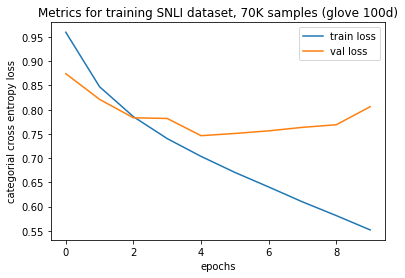

In [95]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
x = np.arange(len(history.history['loss']))
ax.plot(x, history.history['loss'], label="train loss")
ax.plot(x, history.history['val_loss'], label="val loss")
plt.xlabel("epochs")
plt.ylabel("categorial cross entropy loss")
ax.legend()
plt.title("Metrics for training SNLI dataset, 70K samples (glove 100d)")
#history.history['loss']

In [94]:
model.load_weights(checkpoint_filepath)
model.evaluate(val_dataset)

468/468 [==============================] - 40s 85ms/step - loss: 0.7687 - accuracy: 0.6780


[0.7687164545059204, 0.6780181527137756]

### Alternate
Trying the code from [here](https://github.com/songyang0716/NLP/blob/master/natural_language_inference/sentence_encoding_RNN/model.py)
and [concatenate lstm stackoverflow](https://stackoverflow.com/questions/53956998/how-can-i-concatenate-two-lstm-with-keras)

In [59]:
vocab_size= len(lang_tokenizer.word_index)
dim = embedding_matrix.shape[1]
#dim = 50 #keep it same as the dim of the embedding matrix so that we can compare
embedding_hyp_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)
embedding_evi_layer = tf.keras.layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=dim,
        weights=[embedding_matrix],
        trainable=False,
        # Use masking to handle the variable sequence lengths
        mask_zero=True)

inp1 = keras.Input(shape=(None,))
inp2 = keras.Input(shape=(None,))
x_hyp = embedding_hyp_layer(inp1)
x_evi = embedding_evi_layer(inp2)

#this throws an error in the d type instances in AWS, works on p type instances
#hyp_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(dim))(x_hyp)
hyp_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_hyp)
hyp_evi = tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(dim)))(x_evi)

#tf.keras.layers.Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(64))),
w = keras.layers.concatenate([hyp_lstm, hyp_evi], axis = 1)

x3 = tf.keras.layers.Dense(16, activation='relu')(w)
x4 = tf.keras.layers.Dropout(0.1)(x3)
output = tf.keras.layers.Dense(3, activation='softmax')(x4)
    
model1 = keras.Model(inputs=[inp1, inp2], outputs=output)
model1.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(), 
          metrics=['accuracy'])
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 100)    2567500     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 100)    2567500     input_8[0][0]                    
____________________________________________________________________________________________

In [60]:
print(hyp_tokens.shape)
print(evi_tokens.shape)

(300000, 84)
(300000, 62)


In [61]:
from sklearn.model_selection import train_test_split
input_tensor_train_h, input_tensor_val_h, input_tensor_train_e, input_tensor_val_e, target_tensor_train, target_tensor_val = train_test_split(hyp_tokens, evi_tokens, train_labels, test_size=0.3)

In [62]:
print(input_tensor_train_h.shape)
print(input_tensor_val_h.shape)
print(input_tensor_train_e.shape)
print(input_tensor_val_e.shape)
print(target_tensor_train.shape)
print(target_tensor_val.shape)

(210000, 84)
(90000, 84)
(210000, 62)
(90000, 62)
(210000, 3)
(90000, 3)


In [37]:
# BUFFER_SIZE = 32000
# BATCH_SIZE = 64
# train_dataset = tf.data.Dataset.from_tensor_slices(({'input_6': input_tensor_train_h, 'input_7': input_tensor_train_e}, target_tensor_train))
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
# val_dataset = tf.data.Dataset.from_tensor_slices(({'input_6': input_tensor_val_h, 'input_7': input_tensor_val_e}, target_tensor_val))
# val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [76]:
BUFFER_SIZE = 32000
BATCH_SIZE = 64
print(type(input_tensor_train_h))
dataset_12 = tf.data.Dataset.from_tensor_slices((input_tensor_train_h, input_tensor_train_e))
print(dataset_12)
dataset_label = tf.data.Dataset.from_tensor_slices(target_tensor_train)

train_dataset = tf.data.Dataset.zip((dataset_12, dataset_label))
print(train_dataset)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(train_dataset)

dataset_12_val = tf.data.Dataset.from_tensor_slices((input_tensor_val_h, input_tensor_val_e))
dataset_label_val = tf.data.Dataset.from_tensor_slices(target_tensor_val)

val_dataset = tf.data.Dataset.zip((dataset_12_val, dataset_label_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

<class 'numpy.ndarray'>
<TensorSliceDataset shapes: ((84,), (62,)), types: (tf.int32, tf.int32)>
<ZipDataset shapes: (((84,), (62,)), (3,)), types: ((tf.int32, tf.int32), tf.float64)>
<BatchDataset shapes: (((64, 84), (64, 62)), (64, 3)), types: ((tf.int32, tf.int32), tf.float64)>


In [64]:
for t in train_dataset.take(1):
    print(len(t))
    print(t[0][1])
    print(t[1])

2
tf.Tensor(
[[  3   6  15 ...   0   0   0]
 [  3   2 130 ...   0   0   0]
 [  3   2 263 ...   0   0   0]
 ...
 [  3 671   7 ...   0   0   0]
 [  3  53  12 ...   0   0   0]
 [  3  16  85 ...   0   0   0]], shape=(64, 62), dtype=int32)
tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.

In [66]:
checkpoint_filepath = 'tmp/checkpoint_bowman_2'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [67]:
ls tmp

checkpoint  checkpoint_bowman_2.data-00000-of-00001  checkpoint_bowman_2.index


In [68]:
rm -rf tmp/checkpoint*

In [69]:
ls tmp/

In [48]:
train_dataset

<BatchDataset shapes: (((64, 84), (64, 46)), (64, 3)), types: ((tf.int32, tf.int32), tf.float64)>

In [41]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    1645200     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200)          160800      embedding[1][0]            

In [34]:
# physical_devices = tf.config.list_physical_devices('GPU')
# print(physical_devices)
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [70]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [72]:
train_dataset

<BatchDataset shapes: (((64, 84), (64, 62)), (64, 3)), types: ((tf.int32, tf.int32), tf.float64)>

In [71]:
#since we are creating variables in the first call, we need to set this parameter, to run functions eagerly
#tf.config.run_functions_eagerly(True)
history1 = model1.fit(train_dataset, epochs=20,
                    callbacks=[stop_early, model_checkpoint_callback],
                    validation_data=val_dataset,
                    validation_steps=30)

Epoch 1/20
1380/3281 [===========>..................] - ETA: 6:21 - loss: 0.9487 - accuracy: 0.5333

KeyboardInterrupt: 

In [45]:
print(keras.__version__)

2.5.0
